<a href="https://colab.research.google.com/github/jideilori/DepthNet/blob/main/TF_DepthNet_nyuv2_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resnet18

In [2]:
# slightly modified version from https://github.com/dexter2406/Monodepth2-TF2
import tensorflow as tf
from tensorflow.keras.layers import Lambda
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D, \
BatchNormalization, Layer, Add,ZeroPadding2D, Activation
from tensorflow.keras.models import Sequential, Model

from keras import backend as K
# K.get_session().graph.get_collection('variables')
# K.clear_session()

class BasicBlock_nopad(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1, block_id=-1, layer_id=-1):
        super(BasicBlock_nopad, self).__init__()
        prefix = 'conv%d_%d/' % (block_id, layer_id)
        # 1
        self.conv1 = Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride,
                            use_bias=False, padding="same", name=''.join([prefix, 'conv_1']))
        self.bn1 = BatchNormalization(name=''.join([prefix, 'BatchNorm_1']))
        self.a1 = Activation('relu')
        # 2
        self.conv2 = Conv2D(filters=filter_num, kernel_size=(3, 3),
                            use_bias=False, padding="same")
        self.bn2 = BatchNormalization(name=''.join([prefix, 'BatchNorm_2']))
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride,
                                       use_bias=False, padding="same", name=''.join([prefix, 'downsample'])))
            self.downsample.add(BatchNormalization(name='downsample/BatchNorm_3'))
        else:
            self.downsample = lambda x: x
        self.a2 = Activation('relu')

    def call(self, x, training=None, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.a1(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        identity = self.downsample(x)

        out = tf.keras.layers.add([identity, out])
        out = self.a2(out)
        return out

class BasicBlock_pad(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1, padding_mode='same', block_id=-1, layer_id=-1):
        super(BasicBlock_pad, self).__init__()
        padding = 'same'
        prefix = 'conv%d_%d/' % (block_id, layer_id)
        # 1
        self.conv1 = Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride,
                            use_bias=False, padding=padding, name=''.join([prefix, 'conv_1']))
        self.bn1 = BatchNormalization(name=''.join([prefix, 'BatchNorm_1']))
        self.a1 = Activation('relu')
        # 2
        self.conv2 = Conv2D(filters=filter_num, kernel_size=(3, 3),
                            use_bias=False, padding=padding)
        self.bn2 = BatchNormalization(name=''.join([prefix, 'BatchNorm_2']))

        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride,
                                       use_bias=False, padding='same', name=''.join([prefix, 'downsample'])))
            self.downsample.add(BatchNormalization(name='downsample/BatchNorm_3'))
        else:
            self.downsample = lambda x: x
        self.a2 = Activation('relu')

    def call(self, x, training=None, **kwargs):

        out = x
        out = self.conv1(out)
        out = self.bn1(out, training=training)
        out = self.a1(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        identity = self.downsample(x)

        out = tf.keras.layers.add([identity, out])
        out = self.a2(out)
        return out

class ResNet18_new(tf.keras.Model):
    def __init__(self, block_list=[2, 2, 2, 2], initial_filters=64, norm_inp=False):
        super(ResNet18_new, self).__init__()
        self.norm_inp = norm_inp

        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.out_filters = initial_filters

        self.conv1 = Conv2D(filters=self.out_filters, kernel_size=(7, 7), strides=2,
                            use_bias=False, padding='same', name='conv1')
        self.bn1 = BatchNormalization(name='bn1')
        self.a1 = Activation('relu', name='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same", name='maxpool')

        self.layer1 = self._make_basic_block_layer(filter_num=64, blocks=block_list[0], block_id=1)
        self.layer2 = self._make_basic_block_layer(filter_num=128, blocks=block_list[1], stride=2, block_id=2)
        self.layer3 = self._make_basic_block_layer(filter_num=256, blocks=block_list[2], stride=2, block_id=3)
        self.layer4 = self._make_basic_block_layer(filter_num=512, blocks=block_list[3], stride=2, block_id=4)

    def _make_basic_block_layer(self, filter_num, blocks, stride=1, block_id=-1):
        res_block = tf.keras.Sequential(name='seq_%d' % block_id)
        res_block.add(BasicBlock_pad(filter_num, stride=stride, block_id=block_id, layer_id=1, padding_mode='same'))

        for i in range(1, blocks):
            res_block.add(BasicBlock_nopad(filter_num, stride=1, block_id=block_id, layer_id=i + 1))

        return res_block

    def is_train(self, block_id, unfreeze_num, training):
        if unfreeze_num is None:
            return training
        num_blocks = 5
        return (num_blocks-block_id) <= unfreeze_num

    def call(self, inputs, training=None, mask=None, unfreeze_num=None):
        if self.norm_inp:
            inputs = (inputs - 0.5) * 2
        outputs = []
        x = inputs
        x = self.conv1(x)
        x = self.bn1(x, training=self.is_train(0, unfreeze_num, training))
        x = self.a1(x)
        outputs.append(x)
        x = self.pool1(x)
        x = self.layer1(x, training=self.is_train(1, unfreeze_num, training))

        outputs.append(x)
        x = self.layer2(x, training=self.is_train(2, unfreeze_num, training))
        outputs.append(x)
        x = self.layer3(x, training=self.is_train(3, unfreeze_num, training))
        outputs.append(x)
        x = self.layer4(x, training=self.is_train(4, unfreeze_num, training))
        outputs.append(x)
        return outputs
        
resnet18_model = ResNet18_new([2, 2, 2, 2],norm_inp=False)


## model

In [3]:
from collections import OrderedDict
import numpy as np
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras import backend as K
from collections import OrderedDict
from tensorflow.keras.layers import Lambda
import numpy as np

from typing import Dict, Any
import tensorflow
from tensorflow.keras import layers
from tensorflow.python.training.tracking.data_structures import NoDependency


class TF_simple_conv_block_new(tensorflow.keras.layers.Layer):
    def __init__(self,in_channels,out_channels):
        super(TF_simple_conv_block_new, self).__init__()
        self.conv = TF_conv_3x3_new(in_channels,out_channels)
        self.nonlin = tf.keras.layers.ELU(alpha=1.0)

    def build(self, input_shape):
          self.kernel = self.add_weight(name='kernel', 
                                    shape=(input_shape[1],input_shape[2]),
                                    initializer='he_uniform',
                                    trainable=True)
          super(TF_simple_conv_block_new, self).build(input_shape)  

    def call(self, inputs):
      return self.nonlin(self.conv(inputs))
    
    
class TF_conv_3x3_new(tensorflow.keras.layers.Layer):
    def __init__(self,in_channels, out_channels, use_refl=True):
        super(TF_conv_3x3_new, self).__init__()
        self.reflect_pad = Lambda(lambda x: tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], 'REFLECT'))
        self.zeropad = Lambda(lambda x:tf.pad(x,[[0,0],[1,1],[1,1],[0,0]],'CONSTANT'))
        if use_refl:
          self.pad = self.reflect_pad
        else:
          self.pad = self.zeropad
        self.conv = tf.keras.layers.Conv2D(out_channels,3)
    
    def build(self, input_shape):
          self.kernel = self.add_weight(name='kernel', 
                                    shape=(input_shape[1],input_shape[2]),
                                    initializer='he_uniform',
                                    trainable=True)
          super(TF_conv_3x3_new, self).build(input_shape)  


    def call(self, inputs):
      return self.conv(self.pad(inputs))


class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super(DepthEstimationModel,self).__init__()
       
        self.tf_num_layers: int = 18 #choices=[18, 34, 50, 101, 152]
        self.tf_scales: list = range(4)  #0,1,2,3 
        self.tf_use_skips: bool = True
      
        self.tf_enc_ch = np.array([64, 64, 128, 256, 512])
        self.tf_dec_ch = np.array([16, 32, 64, 128, 256])
        if self.tf_num_layers > 34:
          self.tf_enc_ch[1:] *= 4

        # Build multiscale decoder
        self.tf_convs = NoDependency({})
        for i in range(4, -1, -1):
            self.tf_in_ch = self.tf_enc_ch[-1] if i == 4 else self.tf_dec_ch[i + 1]
            self.tf_convs[('upconv', i, 0)] = TF_simple_conv_block_new(self.tf_in_ch, self.tf_dec_ch[i])

            self.tf_in_ch = self.tf_dec_ch[i] + (self.tf_enc_ch[i - 1] if self.tf_use_skips and i > 0 else 0)
            self.tf_convs[('upconv', i, 1)] = TF_simple_conv_block_new(self.tf_in_ch, self.tf_dec_ch[i])

        # Upsample convs for each scale
        for s in self.tf_scales:
            self.tf_convs[('dispconv', s)] = TF_conv_3x3_new(self.tf_dec_ch[s], 1)
        
        self.res_model= resnet18_model

       
    def call(self, inputs):
        
        tf_features, tf_outputs = [], {}
        tfx = self.res_model.get_layer('conv1')(inputs)
        tfx = self.res_model.get_layer('bn1')(tfx)
        tf_features.append(self.res_model.get_layer('relu')(tfx))

        tf_features.append(self.res_model.get_layer('seq_1')(self.res_model.get_layer('maxpool')(tf_features[-1])))
        tf_features.append(self.res_model.get_layer('seq_2')(tf_features[-1]))
        tf_features.append(self.res_model.get_layer('seq_3')(tf_features[-1]))
        tf_features.append(self.res_model.get_layer('seq_4')(tf_features[-1]))

        # Decoder
        x = tf_features[-1]        
        for i in range(4, -1, -1):
          x = self.tf_convs[('upconv', i, 0)](x)
          x = tensorflow.keras.layers.UpSampling2D()(x)
          if self.tf_use_skips and i > 0:
              x = Concatenate(axis=3)([x, tf_features[i - 1]])
          x=self.tf_convs[('upconv', i, 1)](x)
          if i in self.tf_scales:
              out = self.tf_convs[('dispconv', i)](x)
              # tf_outputs["output_%d" % i] = tf.math.sigmoid(out)
              # out = tf.math.sigmoid(out)
        
        return out

    
model = DepthEstimationModel()
inp = tensorflow.keras.layers.Input(shape=(480,640,3))
output = model(inp)
model = tf.keras.Model(inputs=inp, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 depth_estimation_model (Dep  (None, 480, 640, 1)      11186112  
 thEstimationModel)                                              
                                                                 
Total params: 11,186,112
Trainable params: 11,176,512
Non-trainable params: 9,600
_________________________________________________________________


## Data - root

In [4]:
!git clone https://github.com/jideilori/DenseDepth
%cd /content/DenseDepth/

Cloning into 'DenseDepth'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 298 (delta 23), reused 25 (delta 7), pack-reused 242
Receiving objects: 100% (298/298), 12.14 MiB | 26.29 MiB/s, done.
Resolving deltas: 100% (142/142), done.
/content/DenseDepth


In [5]:
!cp /content/drive/MyDrive/nyu_data.zip /content/DenseDepth/nyu_data.zip

In [6]:
!unzip -q /content/DenseDepth/nyu_data.zip

In [7]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip

--2022-04-11 18:06:16--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.211
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406362472 (1.3G) [application/zip]
Saving to: ‘nyu_test.zip’

nyu_test.zip        100%[===================>]   1.31G  28.4MB/s    in 48s     

2022-04-11 18:07:05 (27.7 MB/s) - ‘nyu_test.zip’ saved [1406362472/1406362472]



## train

In [8]:
import numpy as np
from utils import DepthNorm
from io import BytesIO
from PIL import Image
from zipfile import ZipFile
from tensorflow.keras.utils import Sequence
from augment import BasicPolicy

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

def nyu_resize(img, resolution=480, padding=6):
    from skimage.transform import resize
    return resize(img, (resolution, int(resolution*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True )

def get_nyu_data(batch_size, nyu_data_zipfile='nyu_data.zip'):
    data = extract_zip(nyu_data_zipfile)

    nyu2_train = list((row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n') if len(row) > 0))
    nyu2_test = list((row.split(',') for row in (data['data/nyu2_test.csv']).decode("utf-8").split('\n') if len(row) > 0))

    shape_rgb = (batch_size, 480, 640, 3)
    shape_depth = (batch_size, 480, 640, 1)

    # Helpful for testing...
    if False:
        nyu2_train = nyu2_train[:10]
        nyu2_test = nyu2_test[:10]

    return data, nyu2_train, nyu2_test, shape_rgb, shape_depth

def get_nyu_train_test_data(batch_size):
    data, nyu2_train, nyu2_test, shape_rgb, shape_depth = get_nyu_data(batch_size)

    train_generator = NYU_BasicAugmentRGBSequence(data, nyu2_train, batch_size=batch_size, shape_rgb=shape_rgb, shape_depth=shape_depth)
    test_generator = NYU_BasicRGBSequence(data, nyu2_test, batch_size=batch_size, shape_rgb=shape_rgb, shape_depth=shape_depth)

    return train_generator, test_generator

class NYU_BasicAugmentRGBSequence(Sequence):
    def __init__(self, data, dataset, batch_size, shape_rgb, shape_depth, is_flip=False, is_addnoise=False, is_erase=False):
        self.data = data
        self.dataset = dataset
        self.policy = BasicPolicy( color_change_ratio=0.50, mirror_ratio=0.50, flip_ratio=0.0 if not is_flip else 0.2, 
                                    add_noise_peak=0 if not is_addnoise else 20, erase_ratio=-1.0 if not is_erase else 0.5)
        self.batch_size = batch_size
        self.shape_rgb = shape_rgb
        self.shape_depth = shape_depth
        self.maxDepth = 1000.0

        from sklearn.utils import shuffle
        self.dataset = shuffle(self.dataset, random_state=0)

        self.N = len(self.dataset)

    def __len__(self):
        return int(np.ceil(self.N / float(self.batch_size)))

    def __getitem__(self, idx, is_apply_policy=True):
        batch_x, batch_y = np.zeros( self.shape_rgb ), np.zeros( self.shape_depth )

        # Augmentation of RGB images
        for i in range(batch_x.shape[0]):
            index = min((idx * self.batch_size) + i, self.N-1)

            sample = self.dataset[index]
            
            x = np.clip(np.asarray(Image.open( "./"+sample[0] )).reshape(480,640,3)/255,0,1)
            y = np.clip(np.asarray(Image.open( "./"+sample[1] )).reshape(480,640,1)/255*self.maxDepth,0,self.maxDepth)
            y = DepthNorm(y, maxDepth=self.maxDepth)

            batch_x[i] = nyu_resize(x, 480)
            batch_y[i] = nyu_resize(y, 480)

            if is_apply_policy: batch_x[i], batch_y[i] = self.policy(batch_x[i], batch_y[i])

            # DEBUG:
            #self.policy.debug_img(batch_x[i], np.clip(DepthNorm(batch_y[i])/maxDepth,0,1), idx, i)
        #exit()

        return batch_x, batch_y

class NYU_BasicRGBSequence(Sequence):
    def __init__(self, data, dataset, batch_size,shape_rgb, shape_depth):
        self.data = data
        self.dataset = dataset
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.shape_rgb = shape_rgb
        self.shape_depth = shape_depth
        self.maxDepth = 1000.0

    def __len__(self):
        return int(np.ceil(self.N / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x, batch_y = np.zeros( self.shape_rgb ), np.zeros( self.shape_depth )
        for i in range(self.batch_size):            
            index = min((idx * self.batch_size) + i, self.N-1)

            sample = self.dataset[index]

            x = np.clip(np.asarray(Image.open( "./"+sample[0])).reshape(480,640,3)/255,0,1)
            y = np.asarray(Image.open( "./"+sample[1]), dtype=np.float32).reshape(480,640,1).copy().astype(float) / 10.0
            y = DepthNorm(y, maxDepth=self.maxDepth)

            batch_x[i] = nyu_resize(x, 480)
            batch_y[i] = nyu_resize(y, 480)

            # DEBUG:
            #self.policy.debug_img(batch_x[i], np.clip(DepthNorm(batch_y[i])/maxDepth,0,1), idx, i)
        #exit()

        return batch_x, batch_y


In [ ]:
import os, sys, glob, time, pathlib, argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

# Kerasa / TensorFlow
from loss import depth_loss_function
from utils import predict, save_images, load_test_data
from model import create_model
# from data import get_nyu_train_test_data, get_unreal_train_test_data
from callbacks import get_nyu_callbacks

from tensorflow.keras.optimizers import Adam
#from keras.utils import multi_gpu_model
from tensorflow.keras.utils import plot_model

args_data = 'nyu'
args_lr = 0.0001
args_bs = 4
args_epochs = 2
args_gpus = 1
args_gpuids = '0'
args_mindepth = 10
args_maxdepth = 1000
args_name = 'densedepth_nyu'
args_checkpoint = ''
args_full = 'full'

# parser.add_argument('--full', dest='full', action='store_true', help='Full training with metrics, checkpoints, and image samples.')

if args_gpus == 1: 
    os.environ['CUDA_VISIBLE_DEVICES'] = args_gpuids
    print('Will use GPU ' + args_gpuids)
else:
    print('Will use ' + str(args_gpus) + ' GPUs.')

# Create the model
# model = create_model( existing=args_checkpoint )

# Data loaders
if args_data == 'nyu': train_generator, test_generator = get_nyu_train_test_data( args_bs )
# if args_data == 'unreal': train_generator, test_generator = get_unreal_train_test_data( args_bs )

# Training session details
runID = str(int(time.time())) + '-n' + str(len(train_generator)) + '-e' + str(args_epochs) + '-bs' + str(args_bs) + '-lr' + str(args_lr) + '-' + args_name
outputPath = './models/'
runPath = outputPath + runID
pathlib.Path(runPath).mkdir(parents=True, exist_ok=True)
print('Output: ' + runPath)

 # (optional steps)
# if True:
#     # Keep a copy of this training script and calling arguments
#     with open(__file__, 'r') as training_script: training_script_content = training_script.read()
#     training_script_content = '#' + str(sys.argv) + '\n' + training_script_content
#     with open(runPath+'/'+__file__, 'w') as training_script: training_script.write(training_script_content)

#     # Generate model plot
#     plot_model(model, to_file=runPath+'/model_plot.png', show_shapes=True, show_layer_names=True)

#     # Save model summary to file
#     from contextlib import redirect_stdout
#     with open(runPath+'/model_summary.txt', 'w') as f:
#         with redirect_stdout(f): model.summary()

# Multi-gpu setup:
basemodel = model
if args_gpus > 1: model = multi_gpu_model(model, gpus=args_gpus)

# Optimizer
optimizer = Adam(learning_rate=args_lr, amsgrad=True)

# Compile the model
print('\n\n\n', 'Compiling model..', runID, '\n\n\tGPU ' + (str(args_gpus)+' gpus' if args_gpus > 1 else args_gpuids)
        + '\t\tBatch size [ ' + str(args_bs) + ' ] ' + ' \n\n')
model.compile(loss=depth_loss_function, optimizer=optimizer)

print('Ready for training!\n')

# Callbacks
callbacks = []
if args_data == 'nyu': callbacks = get_nyu_callbacks(model, basemodel, train_generator, test_generator, load_test_data() if args_full else None , runPath)

# Start training
model.fit(train_generator, validation_data=test_generator, epochs=args_epochs, shuffle=True)

# Save the final trained model:


Will use GPU 0
Output: ./models/1649700457-n12672-e2-bs4-lr0.0001-densedepth_nyu



 Compiling model.. 1649700457-n12672-e2-bs4-lr0.0001-densedepth_nyu 

	GPU 0		Batch size [ 4 ]  


Ready for training!

Loading test data...Test data loaded.

Epoch 1/2


In [8]:
model.save_weights(runPath + '/test_model')

In [23]:
from loss import depth_loss_function
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001, amsgrad=True)


model.load_weights('/content/DenseDepth/models/1649515729-n3-e2-bs4-lr0.0001-densedepth_nyu/test_model')


## Testing

In [24]:
import os
import glob
import time
import argparse

# Kerasa / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from utils import predict, load_images, display_images, evaluate
from matplotlib import pyplot as plt

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

# Load model into GPU / CPU
print('Loading model...')
# model = load_model(args_model, custom_objects=custom_objects, compile=False)

# Load test data
print('Loading test data...', end='')
import numpy as np
from data import extract_zip
data = extract_zip('nyu_test.zip')
from io import BytesIO
rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
depth = np.load(BytesIO(data['eigen_test_depth.npy']))
crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

start = time.time()
print('Testing...')

e = evaluate(model, rgb, depth, crop, batch_size=6)

print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

end = time.time()
print('\nTest time', end-start, 's')

Loading model...
Loading test data...Test data loaded.

Testing...
        a1,         a2,         a3,        rel,        rms,     log_10
    0.0320,     0.0808,     0.1598,     1.7244,     6.2786,     0.5634

Test time 138.7965042591095 s


Loading model...

Loaded (13) images of size (480, 640, 3).
(13, 480, 640, 1)


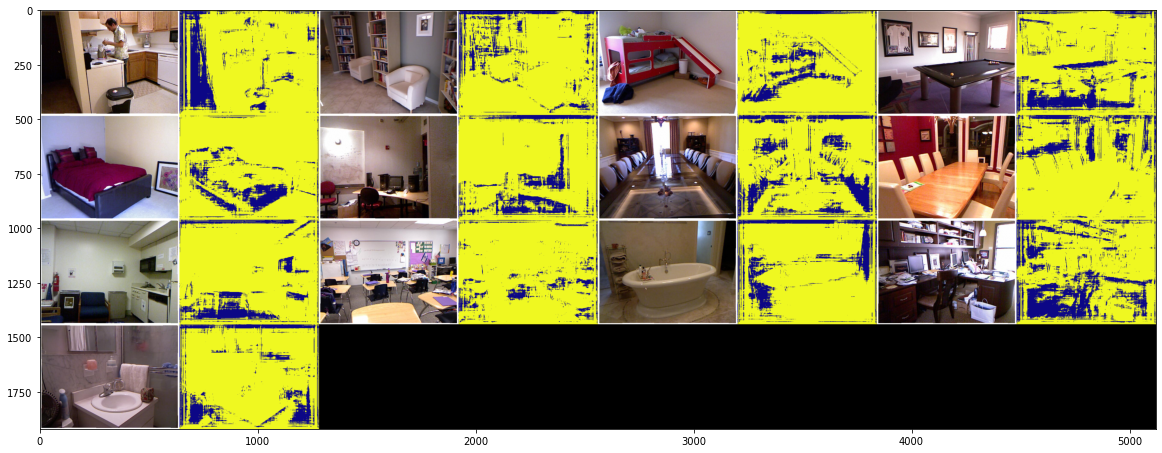

In [54]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from tensorflow.keras.layers import Layer, InputSpec
from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


print('Loading model...')

inputs = load_images( glob.glob('examples/*.png') )
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)
print(outputs.shape)
#matplotlib problem on ubuntu terminal fix
#matplotlib.use('TkAgg')   

# Display results
viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(20,20))
plt.imshow(viz,cmap='plasma')
plt.savefig('test.png')
# plt.show()


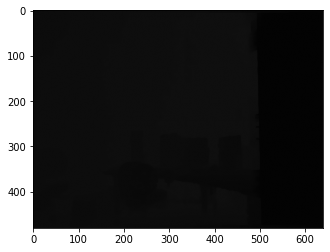

In [41]:
import cv2
test_depth = cv2.imread('/content/DenseDepth/data/nyu2_test/00030_depth.png')
plt.imshow(test_depth,cmap='ocean')

(480, 640, 3)
(1, 480, 640, 3)
(480, 640, 1)


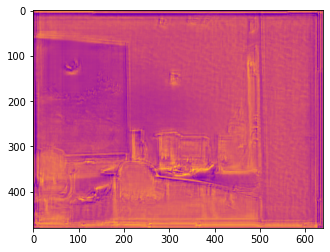

In [49]:
test_depth = cv2.imread('/content/DenseDepth/data/nyu2_test/00030_colors.png')
print(test_depth.shape)
test_depth = np.expand_dims(test_depth,0)
print(test_depth.shape)

pred = model.predict(test_depth).squeeze(0)
print(pred.shape)
plt.imshow(pred.squeeze(2),cmap='plasma')